In [1]:
import gzip, json, glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
pattern = "/tmp/testoutput*"

In [15]:
def load_files(pattern, data={}): # data map (example_i[, target_label]) => data
    for filename in glob.glob(pattern):
        print("Reading file:", filename)
        with gzip.open(filename, "r") as f:
            lines = f.readlines()
            for line in lines:
                j = json.loads(line)
                #print(filename, j.keys())
                example_i = j["example_i"]
                if "target_label" in j:
                    key = (example_i, j["target_label"])
                else:
                    key = example_i

                d = data.get(key, {})
                data[key] = d
                
                if "veritas_deltas" in j:
                    column_prefix = f"veritas{j['max_time']:02d}"
                    d[f"{column_prefix}_time"] = j["veritas_time"]
                    d[f"{column_prefix}_delta"] = j["veritas_deltas"][-1][0]
                
                if "merge_ext" in j and "max_clique" in j["merge_ext"]:
                    column_prefix = f"mext_T{j['merge_ext']['max_clique']}_L{j['merge_ext']['max_level']}"
                    d[f"{column_prefix}_time"] = j["merge_ext"]["times"][-1]
                    d[f"{column_prefix}_delta"] = j["merge_ext"]["deltas"][-1]
                    
                if "kantchelian" in j:
                    column_prefix = "kan"
                    d[f"{column_prefix}_time"] = j["kantchelian"]["time_p"]
                    d[f"{column_prefix}_delta"] = j["kantchelian_delta"]
    return data

def get_column_names(data):
    columns = set()
    for value in data.values():
        columns |= value.keys()
    return sorted(columns)
        

def to_df(data):
    colnames = get_column_names(data)
    columns = {}
    index = pd.Series(list(data.keys()))
    for c in colnames:
        values = {}
        for key, value in data.items():
            if c in value:
                values[key] = value[c]
        columns[c] = values
    df = pd.DataFrame(columns)
    df.set_index(index)
    return df

In [17]:
data = load_files(pattern)
df = to_df(data)
df

Reading file: /tmp/testoutput-mnist-time2-0:2-0001.gz
Reading file: /tmp/testoutput-mnist-time6-0:2-1000.gz
Reading file: /tmp/testoutput-mnist-time4-0:2-1000.gz
Reading file: /tmp/testoutput-mnist-0:2-0e00.gz
Reading file: /tmp/testoutput-mnist-time2-0:2-1000.gz


mext_T2_L2_delta  mext_T2_L2_time  veritas02_delta  veritas02_time  \
0 0         16.992200         0.729561        17.500044        2.296733   
  1         13.007800         0.683704        12.500031        2.154821   
  2          1.992190         4.908060         5.000013        2.239335   
  3          0.976562         1.178640         5.000013        2.159916   
  4         15.976600         0.795362        15.000038        2.028442   
  6          6.992190         1.694190         7.500019        2.333714   
  7          8.007810         0.939366         5.000013        2.075997   
  8          3.007810         1.105690         5.000013        2.064653   
  9          4.960940         0.961242         5.000013        2.079700   
1 1         26.992200         0.607914        26.250066        2.291629   
  2          6.992190         0.587398         7.500019        2.390583   
  3         14.960900         0.574471        15.000038        2.011123   
  4         36.992200         0.625416        45.000113        2.340383   
  5          9.960940         0.857052        12.500031        2.347434   
  6          9.960940         0.462325        12.500031        2.326438   
  7         16.992200         0.416384        17.500044        2.349839   
  8         10.976600         0.525674        15.000038        2.077451   
  9         13.007800         0.400885        12.500031        2.344670   

     veritas04_delta  veritas04_time  veritas06_delta  veritas06_time  
0 0        17.812545        4.115418        18.046920        6.043872  
  1        12.812532        4.089849        13.046908        6.030751  
  2         1.250003        4.166899         2.031255        6.400446  
  3         0.625002        4.373483         0.937502        6.052277  
  4        16.875042        4.025049        17.031293        6.010870  
  6         7.812520        4.327833         8.046895        6.278563  
  7         8.125020        4.103569         8.906272        6.022318  
  8         3.125008        4.418468         2.968757        6.232470  
  9         5.625014        4.263320         6.093765        6.109779  
1 1        27.031318        4.150284        26.992255        5.950344  
  2         7.187518        4.428335         6.953142        6.343901  
  3        15.937540        4.416460        17.031293        6.123868  
  4        41.250103        4.095243        40.312601        6.302558  
  5        11.562529        4.330135        11.953155        6.474726  
  6        12.187530        4.066422        11.953155        6.311182  
  7        20.312551        4.370629        20.781302        6.153637  
  8        12.812532        4.246953        13.046908        6.248448  
  9        15.312538        4.266202        16.015665        6.308901

In [18]:
mean = df.mean()
std = df.std()

<ErrorbarContainer object of 3 artists>

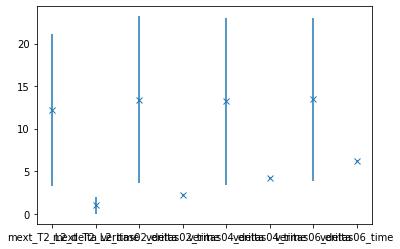

In [19]:
#plt.scatter(mean.index, mean)
plt.errorbar(mean.index, mean, yerr=std, ls="", marker="x")